In [1]:
import os, re, magic, shutil
from glob import glob
import time, datetime
import random
import pandas as pd
import numpy as np
from tqdm import tqdm
import shutil
import warnings
import joblib

import cv2
from PIL import Image
import matplotlib.pyplot as plt
import torch, gc
from torch import nn
from torch.utils.data import Dataset,DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler
from torch.cuda.amp import autocast, GradScaler
from torch.nn.modules.loss import _WeightedLoss
import torch.nn.functional as F
import torchvision
from torchvision import transforms

import sklearn
#from skimage import io
from sklearn.model_selection import GroupKFold, StratifiedKFold
from sklearn.metrics import roc_auc_score, log_loss
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from scipy.ndimage import zoom

import timm
from timm.data import resolve_data_config
from timm.data.transforms_factory import create_transform

import wandb

In [2]:
#path = '../../Data/Training/원천데이터/'
path = 'Data/car_dataset_sample/'
img_names = []
img_labels = []

for folder, subfolders, filenames in os.walk(path):
    for img in filenames:
        img_names.append(folder+'/'+img)
        img_labels.append(img[9:18])

print('Images: ',len(img_names))
print("Image_labels:", len(img_labels))

Images:  1897
Image_labels: 1897


In [4]:
from sklearn.preprocessing import LabelEncoder

# 라벨인코더 선언 및 Fitting
le = LabelEncoder()
le.fit(img_labels)

# 인코딩한 데이터로 변환
le_encoded = le.transform(img_labels)

# 결과물을 확인하면 array 형태로 나옵니다.
# 아래는 라벨 인코딩으로 만들어낸 데이터를 데이터 프레임으로 만들어주는 코드입니다.
new_cat = pd.DataFrame(le_encoded, columns = ['result'])

# 아래 코드를 실행시키면 인코딩된 class를 확인할 수 있습니다.
new_cat


,result
0,0
1,0
2,0
3,0
4,0
...,...
1892,143
1893,143
1894,143
1895,143


In [7]:
first = le.inverse_transform([360])
first

array(['VO_078_18'], dtype='<U9')

In [4]:
trn_df = pd.DataFrame(img_names, columns=['image_id'])
trn_df['dir'] = trn_df['image_id'].apply(lambda x: os.path.dirname(x))
trn_df['image_id'] = trn_df['image_id'].apply(lambda x: os.path.basename(x))
trn_df['label'] = new_cat
train = trn_df
train

,image_id,dir,label
0,C_211222_AU_006_17_BK_A_P_01_054.jpg,Data/car_dataset_sample/AU_아우디/006_A4/2017_검정_트림A,0
1,C_211222_AU_006_17_BK_A_P_01_061.jpg,Data/car_dataset_sample/AU_아우디/006_A4/2017_검정_트림A,0
2,C_211222_AU_006_17_BK_A_T_03_021.jpg,Data/car_dataset_sample/AU_아우디/006_A4/2017_검정_트림A,0
3,C_211223_AU_006_17_BK_B_P_01_003.jpg,Data/car_dataset_sample/AU_아우디/006_A4/2017_검정_트림B,0
4,C_211223_AU_006_17_BK_B_P_01_048.jpg,Data/car_dataset_sample/AU_아우디/006_A4/2017_검정_트림B,0
...,...,...,...
1892,C_211111_SS_097_21_RE_A_P_01_031.jpg,Data/car_dataset_sample/SS_쌍용/097_티볼리/2021_빨강_트림A,143
1893,C_211111_SS_097_21_RE_A_P_01_057.jpg,Data/car_dataset_sample/SS_쌍용/097_티볼리/2021_빨강_트림A,143
1894,C_211111_SS_097_21_RE_B_P_01_031.jpg,Data/car_dataset_sample/SS_쌍용/097_티볼리/2021_빨강_트림B,143
1895,C_211111_SS_097_21_RE_B_P_01_058.jpg,Data/car_dataset_sample/SS_쌍용/097_티볼리/2021_빨강_트림B,143


In [5]:
train.label.value_counts()

23     69
10     51
18     45
43     42
95     39
       ..
28      3
29      3
111     3
34      3
33      3
Name: label, Length: 144, dtype: int64

In [8]:
print(len(train.label))

257740


In [10]:
train.dir.values

array(['Data/car_data/car/1.Training/원천데이터/VO_폭스바겐/078_파사트/2018_흰색_트림B',
       'Data/car_data/car/1.Training/원천데이터/VO_폭스바겐/078_파사트/2018_흰색_트림B',
       'Data/car_data/car/1.Training/원천데이터/VO_폭스바겐/078_파사트/2018_흰색_트림B',
       ...,
       'Data/car_data/car/1.Training/원천데이터/BM_BMW/039_X5/2021_검정_트림A',
       'Data/car_data/car/1.Training/원천데이터/BM_BMW/039_X5/2021_검정_트림A',
       'Data/car_data/car/1.Training/원천데이터/BM_BMW/039_X5/2021_검정_트림A'],
      dtype=object)

In [62]:
print(train.dir.values[0])

Data/car_data/car/1.Training/원천데이터/VO_폭스바겐/078_파사트/2018_흰색_트림B


In [60]:
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
folds_split = folds.split(np.arange(train.shape[0]), train.label.values)
for fold, (trn_idx, val_idx) in enumerate(folds_split):
#print(f'trn_idx:{trn_idx}, val_idx: {val_idx}, fold: {fold}')
    print(f'{fold}st : trn: {trn_idx}')
    print(f'{fold}st : val: {val_idx}')

train_ = train.loc[trn_idx,:].reset_index(drop=True)
valid_ = train.loc[val_idx,:].reset_index(drop=True)
train_data_root = train.dir.values[trn_idx] #trn_idx에 맞는 dir 뽑기
valid_data_root = train.dir.values[val_idx]
#print(train_)


0st : trn: [     0      1      2 ... 257734 257735 257739]
0st : val: [     6      7     26 ... 257736 257737 257738]
1st : trn: [     0      2      4 ... 257737 257738 257739]
1st : val: [     1      3      5 ... 257728 257733 257735]
2st : trn: [     0      1      2 ... 257737 257738 257739]
2st : val: [     4      8     11 ... 257713 257723 257729]
3st : trn: [     0      1      3 ... 257736 257737 257738]
3st : val: [     2     20     21 ... 257732 257734 257739]
4st : trn: [     1      2      3 ... 257737 257738 257739]
4st : val: [     0      9     12 ... 257716 257717 257724]


array(['Data/car_data/car/1.Training/원천데이터/VO_폭스바겐/078_파사트/2018_흰색_트림B',
       'Data/car_data/car/1.Training/원천데이터/VO_폭스바겐/078_파사트/2018_흰색_트림B',
       'Data/car_data/car/1.Training/원천데이터/VO_폭스바겐/078_파사트/2018_흰색_트림B',
       ...,
       'Data/car_data/car/1.Training/원천데이터/BM_BMW/039_X5/2021_검정_트림A',
       'Data/car_data/car/1.Training/원천데이터/BM_BMW/039_X5/2021_검정_트림A',
       'Data/car_data/car/1.Training/원천데이터/BM_BMW/039_X5/2021_검정_트림A'],
      dtype=object)

In [10]:
train.label.nunique()

370

In [50]:
print(train.shape[0])
k = np.arange(train.shape[0])
k

257740


array([     0,      1,      2, ..., 257737, 257738, 257739])

In [33]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
X = np.array([[10, 20], [30, 40], [11, 22], [33, 44]])
y = np.array([1, 1, 0, 0])
skf = StratifiedKFold(n_splits=2)
skf.get_n_splits(X, y)

print(skf.get_n_splits(X, y))

for train_index, test_index in skf.split(X, y):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

2
TRAIN: [1 3] TEST: [0 2]
TRAIN: [0 2] TEST: [1 3]


In [20]:
folds

<generator object _BaseKFold.split at 0x7f91a06f2ce0>

In [74]:
type(train.label)

pandas.core.series.Series

In [20]:
#train['label'].max()+1
temp = np.eye(train['label'].max()+1)
len(temp)

370

In [78]:
train.labels = np.eye(train['label'].max()+1)


TypeError: can only concatenate str (not "int") to str

In [5]:
project_name = 'test32_car_classification'
user = 'hojunking'
run_name = 'test32_car_classification_efficientnet_lite0_size192'

In [6]:
%run classification_train_efficientnet.ipynb

NameError: name 'train' is not defined

NameError: name 'train' is not defined

In [ ]:
#for train, val separately

In [2]:
#cecum = 1, else = 0

true_path = '/Data/data/data_gsun/Cecum/experiment/train/cecum/'
false_path = '/Data/data/data_gsun/Cecum/experiment/train/non_cecum/'

In [3]:
true_dir = [true_path + x for x in os.listdir(true_path) if '.txt' not in x]
false_dir = [false_path + x for x in os.listdir(false_path) if '.txt' not in x]

In [4]:
random.shuffle(true_dir)
random.shuffle(false_dir)

In [5]:
print(len(true_dir))

1274


In [6]:
true_label = [1]*int(len(true_dir))

In [7]:
print(true_label[:10])

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [8]:
print(len(true_label))

1274


In [9]:
print(len(false_dir))

15000


In [10]:
false_label = [0]*int(len(false_dir))

In [11]:
print(false_label[:10])

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [12]:
print(len(false_label))

15000


In [13]:
whole_dir = true_dir + false_dir

In [14]:
whole_label = true_label + false_label

In [15]:
print(len(whole_dir))

16274


In [16]:
print(len(whole_label))

16274


In [17]:
trn_df = pd.DataFrame(whole_dir, columns=['image_id'])
trn_df['dir'] = trn_df['image_id'].apply(lambda x: os.path.dirname(x))
trn_df['image_id'] = trn_df['image_id'].apply(lambda x: os.path.basename(x))
trn_df['label'] = whole_label
train = trn_df
train

,image_id,dir,label
0,V0480_0024.png,/Data/data/data_gsun/Cecum/experiment/train/cecum,1
1,V0376_0079.png,/Data/data/data_gsun/Cecum/experiment/train/cecum,1
2,V0670_0048.png,/Data/data/data_gsun/Cecum/experiment/train/cecum,1
3,V0307_0073.png,/Data/data/data_gsun/Cecum/experiment/train/cecum,1
4,V0612_0022.png,/Data/data/data_gsun/Cecum/experiment/train/cecum,1
...,...,...,...
16269,V1743_2021_0293_000738.png,/Data/data/data_gsun/Cecum/experiment/train/no...,0
16270,V1485_2021_0035_001495.png,/Data/data/data_gsun/Cecum/experiment/train/no...,0
16271,V1880_2021_0430_003530.png,/Data/data/data_gsun/Cecum/experiment/train/no...,0
16272,V1732_2021_0282_003544.png,/Data/data/data_gsun/Cecum/experiment/train/no...,0


In [18]:
train.label.value_counts()

0    15000
1     1274
Name: label, dtype: int64

In [19]:
#cecum = 1, else = 0

true_val_path = '/Data/data/data_gsun/Cecum/experiment/val/cecum/'
false_val_path = '/Data/data/data_gsun/Cecum/experiment/val/non_cecum/'

In [20]:
true_val_dir = [true_val_path + x for x in os.listdir(true_val_path) if '.txt' not in x]
false_val_dir = [false_val_path + x for x in os.listdir(false_val_path) if '.txt' not in x]

In [21]:
random.shuffle(true_val_dir)
random.shuffle(false_val_dir)

In [22]:
print(len(true_val_dir))

71


In [23]:
true_val_label = [1]*int(len(true_val_dir))

In [24]:
print(true_val_label[:10])

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [25]:
print(len(true_val_label))

71


In [26]:
print(len(false_val_dir))

639


In [27]:
false_val_label = [0]*int(len(false_val_dir))

In [28]:
print(false_val_label[:10])

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [29]:
print(len(false_val_label))

639


In [30]:
whole_val_dir = true_val_dir + false_val_dir

In [31]:
whole_val_label = true_val_label + false_val_label

In [32]:
print(len(whole_val_dir))

710


In [33]:
print(len(whole_val_label))

710


In [34]:
val_df = pd.DataFrame(whole_val_dir, columns=['image_id'])
val_df['dir'] = val_df['image_id'].apply(lambda x: os.path.dirname(x))
val_df['image_id'] = val_df['image_id'].apply(lambda x: os.path.basename(x))
val_df['label'] = whole_val_label
val = val_df
val

,image_id,dir,label
0,V1824_2021_0374_000004.png,/Data/data/data_gsun/Cecum/experiment/val/cecum,1
1,V1533_2021_0083_000723.png,/Data/data/data_gsun/Cecum/experiment/val/cecum,1
2,V1533_2021_0083_000742.png,/Data/data/data_gsun/Cecum/experiment/val/cecum,1
3,V1434_2020_1204_000377.png,/Data/data/data_gsun/Cecum/experiment/val/cecum,1
4,V1533_2021_0083_000750.png,/Data/data/data_gsun/Cecum/experiment/val/cecum,1
...,...,...,...
705,V1434_2020_1204_001067.png,/Data/data/data_gsun/Cecum/experiment/val/non_...,0
706,V0042_2019_0042_002852.png,/Data/data/data_gsun/Cecum/experiment/val/non_...,0
707,V1373_2020_1143_002984.png,/Data/data/data_gsun/Cecum/experiment/val/non_...,0
708,V0042_2019_0042_003166.png,/Data/data/data_gsun/Cecum/experiment/val/non_...,0


In [35]:
val.label.value_counts()

0    639
1     71
Name: label, dtype: int64

In [36]:
project_name = 'cecum_classification'
user = 'honbul'
run_name = 'cecum_classification_efficientnet_lite0_size192'

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: honbul. Use `wandb login --relogin` to force relogin


/home/super/endo_venv/lib/python3.8/site-packages/albumentations/augmentations/dropout/cutout.py:50: FutureWarning: Cutout has been deprecated. Please use CoarseDropout
  warnings.warn(
epoch 0 loss: 0.0238: 100%|█████████████████████████████████████████████████████████| 3000/3000 [10:26<00:00,  4.79it/s]


train accuracy = 0.98053
[[14778   222]
 [  362 14638]]


epoch 0 loss: 0.5145: 100%|█████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 20.92it/s]


validation accuracy = 0.81408
[[512 127]
 [  5  66]]


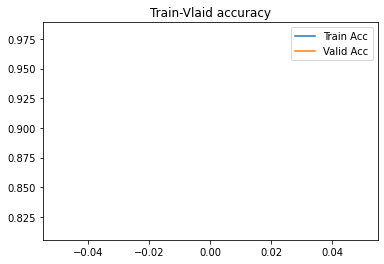

epoch 1 loss: 0.0124: 100%|█████████████████████████████████████████████████████████| 3000/3000 [10:25<00:00,  4.79it/s]


train accuracy = 0.99637
[[14946    54]
 [   55 14945]]


epoch 1 loss: 0.7367: 100%|█████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 21.10it/s]


validation accuracy = 0.70704
[[431 208]
 [  0  71]]


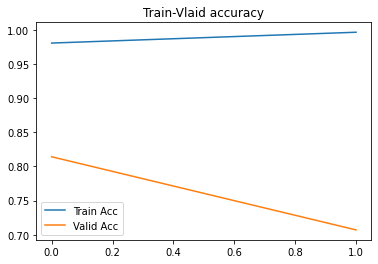

epoch 2 loss: 0.0020: 100%|█████████████████████████████████████████████████████████| 3000/3000 [10:30<00:00,  4.76it/s]


train accuracy = 0.99767
[[14959    41]
 [   29 14971]]


epoch 2 loss: 0.6676: 100%|█████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 21.18it/s]


validation accuracy = 0.80563
[[509 130]
 [  8  63]]


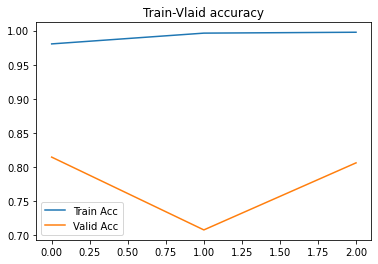

epoch 3 loss: 0.0028: 100%|█████████████████████████████████████████████████████████| 3000/3000 [10:31<00:00,  4.75it/s]


train accuracy = 0.99870
[[14980    20]
 [   19 14981]]


epoch 3 loss: 0.3945: 100%|█████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 20.96it/s]


validation accuracy = 0.85915
[[546  93]
 [  7  64]]


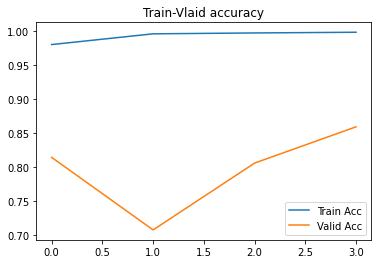

epoch 4 loss: 0.0052: 100%|█████████████████████████████████████████████████████████| 3000/3000 [10:32<00:00,  4.74it/s]


train accuracy = 0.99773
[[14961    39]
 [   29 14971]]


epoch 4 loss: 0.3124: 100%|█████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 21.07it/s]


validation accuracy = 0.88169
[[569  70]
 [ 14  57]]


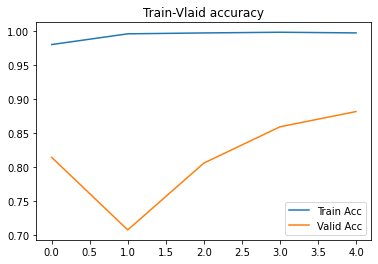

epoch 5 loss: 0.0049:  47%|██████████████████████████▊                              | 1413/3000 [04:58<05:23,  4.90it/s]

In [ ]:
%run classification_train_val_separate_efficientnet.ipynb